In [13]:
import numpy as np
import matplotlib.pyplot as plt
import qutip
import time
import Pulser
from pulser import Pulse, Sequence, Register, Simulation
from pulser.waveforms import ConstantWaveform, RampWaveform, CustomWaveform
from pulser.devices import Chadoq2
from pulser.simresults import SimulationResults

from scipy.optimize import minimize
from scipy.interpolate import PchipInterpolator
from skopt import gp_minimize
from skopt import callbacks
from skopt.utils import cook_initial_point_generator

In [14]:
U_0 = 2 * np.pi * 2.0

Omega_max = 1.0 * U_0 
delta_0 = -2.0 * U_0
delta_f = 1.8 * U_0 
m = 5 
T= 5000

N = 7
W = 0.6

time_domain = np.linspace(0,T,T)
lhs2 = cook_initial_point_generator("lhs", criterion="maximin")

In [15]:
def reg(N, W):
    U =  [U_0 * (1 + np.random.uniform(-W, W)) for _ in range(N)]
    W = [u/U_0-1 for u in U]
    def R(j):
        return Chadoq2.rydberg_blockade_radius(U[j]) 
    coords = np.array([(sum(R(k) for k in range(i)), 0.) for i in range(N)])
    return Register.from_coordinates(coords, prefix='atom'),W

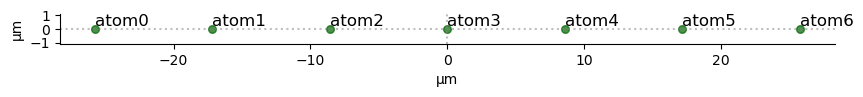

In [16]:
REG,_ = reg(N,0)
REG.draw()

In [17]:
def occupation(j, N):
    up = qutip.basis(2,0)
    prod = [qutip.qeye(2) for _ in range(N)]
    prod[j] = qutip.sigmaz()
    return qutip.tensor(prod)
def stg_mag(state):
    return sum([(-1)**j*(state.dag()*occupation(j,N)*state).tr() for j in range(N)])

In [18]:
seq = Sequence(REG, Chadoq2)
seq.declare_channel('ising', 'rydberg_global')
Omega_max=min([seq.declared_channels['ising'].max_amp, Omega_max])
delta_0=np.sign(delta_0)*min([seq.declared_channels['ising'].max_abs_detuning, abs(delta_0)])
delta_f=np.sign(delta_f)*min([seq.declared_channels['ising'].max_abs_detuning, abs(delta_f)])
print(delta_0/U_0,delta_f/U_0,Omega_max/U_0)
bounds = [(0, Omega_max)] * m + [(delta_0, delta_f)] * m

-2.0 1.8 1.0


In [19]:
def interp_pulse_functions(Omega_pts,delta_pts,T):
    m=len(Omega_pts)
    ti=np.linspace(0,T,m)

    cso = PchipInterpolator(ti,np.array(Omega_pts))
    csd = PchipInterpolator(ti,np.array(delta_pts))
    def Omega(t,*args):
        return cso(t)
    def delta(t,*args):
        return csd(t)
    return Omega,delta
def create_interp_pulse(para):
    Omega_pts = np.r_[1e-9, para[:m], 1e-9]
    delta_pts = np.r_[delta_0, para[m:], delta_f]
    Omega_func, delta_func = interp_pulse_functions(Omega_pts, delta_pts,T)
    Omega,delta=np.array(Omega_func(time_domain)),np.array(delta_func(time_domain))
    return Pulse(CustomWaveform(Omega),CustomWaveform(delta),0)

def interp_seq(reg,para):
    seq = Sequence(reg, Chadoq2)
    seq.declare_channel('ising', 'rydberg_global')
    seq.add(create_interp_pulse(para),'ising')
    return seq

def create_obs(reg,para):
    seq = interp_seq(reg,para)
    simul = Simulation(seq,sampling_rate=0.02)
    results = simul.run()
    return results.expect([occupation(j,N) for j in range(N)])
    

In [26]:
def av_occup_opti(register_dict, op):
    register_dict_opt = {}
    register_dict_unopt = {}
    t_run = 0
    for i in register_dict.keys():
        def score(para):
            expect_val = create_obs(register_dict[i]['reg'],para)
            F = sum([(-1)**j*expect_val[j][-1] for j in range(N)])/N
            return 1 - F
        t1=time.process_time()
        if 'x0' in register_dict[i]:
            RESULT = gp_minimize(score, op['bounds'], n_random_starts = 0, n_calls = 40, verbose=False,initial_point_generator=op['initial_point_generator'],x0=register_dict[i]['x0'],y0=register_dict[i]['y0'], kappa = 0.5)
        else : 
            RESULT = gp_minimize(score, op['bounds'], n_random_starts=op['n_r'], n_calls=op['n_c'], verbose=False,initial_point_generator=op['initial_point_generator'])
        t2=time.process_time()
        t_run+=t2-t1
        print('Score reached for config.{}: '.format(i), np.round(RESULT.fun,3))
        if RESULT.fun < op['score_limit']:
            register_dict_opt[i]={**register_dict[i],**{'para':RESULT.x},**{'score':RESULT.fun}}
        else:
            x0 = [x for _,x in sorted(zip(RESULT.func_vals, RESULT.x_iters))]
            y0 = sorted(RESULT.func_vals)[:op['n_r']]
            x0 = x0[:op['n_r']]
            register_dict_unopt[i]={**register_dict[i],**{'x0':x0,'y0':y0}}
    print('Average run time: ', t_run/len(register_dict))
    print('{}/{}'.format(len(register_dict_opt),len(register_dict)))
    return register_dict_unopt, register_dict_opt

def pulses_optimisation(K, W, op):
    A = 0
    RW = [reg(N,W) for k in range(K)]
    register_dict = {str(i):{'reg':RW[i][0],'W_list':RW[i][1]} for i in range(K)}
    REGISTER_dict_opt = {}
    while len(REGISTER_dict_opt) < K and A<4:
        register_dict, register_dict_opt = av_occup_opti(register_dict, op)
        REGISTER_dict_opt = {**REGISTER_dict_opt,**register_dict_opt}
        A += 1
    print('{}/{}'.format(len(REGISTER_dict_opt),K))
    return register_dict, REGISTER_dict_opt

In [80]:
K=1
RW = [reg(N,W) for k in range(K)]
register_dict = {str(i):{'reg':RW[i][0],'W_list':RW[i][1]} for i in range(K)}

In [81]:
op = {'bounds':bounds,'n_r':30,'n_c':60,'initial_point_generator':lhs2,'score_limit':0.1}
register_dict_unopt, register_dict_opt = av_occup_opti(register_dict, op)

Score reached for config.0:  0.438
Average run time:  132.25
0/1


In [27]:
K = 10

In [28]:
op_006 = {'bounds':bounds,'n_r':30,'n_c':60,'initial_point_generator':lhs2,'score_limit':0.1}
register_dict_unopt_0, REGISTER_dict_opt_0 = pulses_optimisation(K,0.06, op_006)

Score reached for config.0:  0.221
Score reached for config.1:  0.016
Score reached for config.2:  0.146
Score reached for config.3:  0.052
Score reached for config.4:  0.024
Score reached for config.5:  0.08
Score reached for config.6:  0.14
Score reached for config.7:  0.116
Score reached for config.8:  0.094
Score reached for config.9:  0.086
Average run time:  134.6125
6/10
Score reached for config.0:  0.016
Score reached for config.2:  0.111
Score reached for config.6:  0.128
Score reached for config.7:  0.079
Average run time:  180.0625
2/4
Score reached for config.2:  0.093
Score reached for config.6:  0.012
Average run time:  185.28125
2/2
10/10


In [29]:
op_06 = {'bounds':bounds,'n_r':40,'n_c':80,'initial_point_generator':lhs2,'score_limit':0.1}
register_dict_unopt_W, REGISTER_dict_opt_W = pulses_optimisation(K,0.6, op_06)

Score reached for config.0:  0.086
Score reached for config.1:  0.13
Score reached for config.2:  0.435
Score reached for config.3:  0.035
Score reached for config.4:  0.118
Score reached for config.5:  0.405
Score reached for config.6:  0.055
Score reached for config.7:  0.148
Score reached for config.8:  0.251
Score reached for config.9:  0.04
Average run time:  232.4546875
4/10
Score reached for config.1:  0.011
Score reached for config.2:  0.405
Score reached for config.4:  0.084
Score reached for config.5:  0.317
Score reached for config.7:  0.059
Score reached for config.8:  0.251
Average run time:  216.1796875
3/6
Score reached for config.2:  0.061
Score reached for config.5:  0.122
Score reached for config.8:  0.249
Average run time:  241.70833333333334
1/3
Score reached for config.5:  0.112
Score reached for config.8:  0.217
Average run time:  211.421875
0/2
8/10


In [30]:
def av_score_from_dict(register_dict):
    return 1-np.mean([r['score'] for r in register_dict.values()])
def moments_from_dict(register_dict):
    W_list = [r['W_list'] for r in register_dict.values()]
    m_W = sum(np.mean(W_list,axis=0))/N
    var_W = sum(np.var(W_list,axis=0))/N-(2*W)**2/12
    return m_W,var_W
def list_av_expect_from_dict(register_dict):
    return np.mean([create_obs(r['reg'],r['para']) for r in register_dict.values()],axis=0)
def plot_av_occup(E):
    plt.figure()
    color=np.tile(['r','b'], N)
    for j in range(N):
        plt.plot(np.linspace(0,T,len(E[0])),E[j],color=color[j])
    plt.xlabel('Time in '+r'$ns$')
    plt.title(r'$\langle S(T)\rangle_W$'+'={:.3f}'.format(sum([(-1)**j*E[j][-1] for j in range(N)])/N))
    plt.show()

In [31]:
print(av_score_from_dict(REGISTER_dict_opt_0))
print(av_score_from_dict(REGISTER_dict_opt_W))

0.9447537853232701
0.9460321363076422


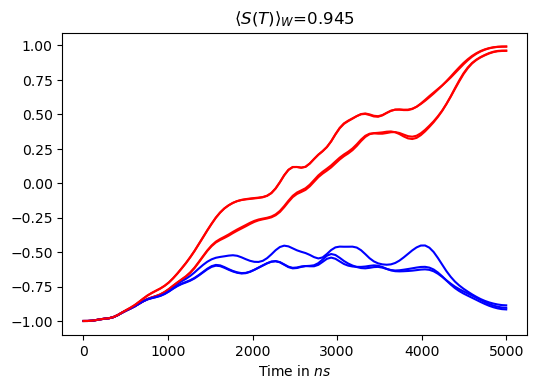

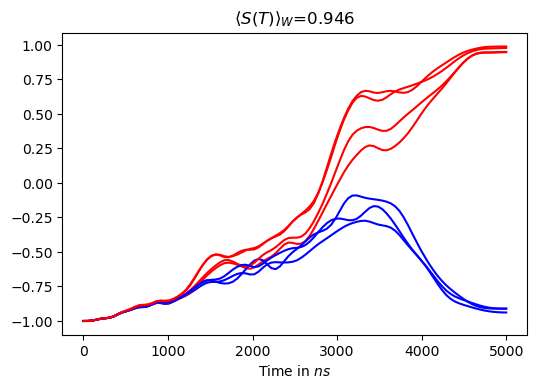

In [32]:
plot_av_occup(list_av_expect_from_dict(REGISTER_dict_opt_0))
plot_av_occup(list_av_expect_from_dict(REGISTER_dict_opt_W))

In [50]:
def seq_quench(reg, para_interp, para_quench):
    seq_q = interp_seq(reg,para_interp)
    seq_q.add(Pulse.ConstantPulse(para_quench[0],para_quench[1], para_quench[2], 0.), 'ising')
    sim = Simulation(seq_q, sampling_rate=0.02)
    results = sim.run()
    expect_val = results.expect([occupation(j,N) for j in range(N)])
    stg_mag = sum([(-1)**j*expect_val[j] for j in range(1,N-1)])
    return stg_mag

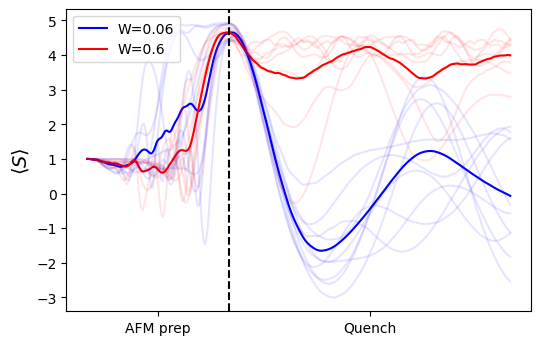

In [62]:
plt.figure()
plt.plot(np.mean([seq_quench(r['reg'],r['para'],[T_quench]+RESULT_quench.x) for r in REGISTER_dict_opt_0.values()],axis=0),'b',label='W={}'.format(0.06))
plt.plot(np.mean([seq_quench(r['reg'],r['para'],[T_quench]+RESULT_quench.x) for r in REGISTER_dict_opt_W.values()],axis=0),'r',label='W={}'.format(0.6))

for r in REGISTER_dict_opt_0.values():
    plt.plot(seq_quench(r['reg'],r['para'],[T_quench]+RESULT_quench.x),'b',alpha=0.1)
for r in REGISTER_dict_opt_W.values():
    plt.plot(seq_quench(r['reg'],r['para'],[T_quench]+RESULT_quench.x),'r',alpha=0.1)
plt.xticks([int(T*0.02/2),int((T+T_quench)*0.02/1.5)],['AFM prep','Quench'])
plt.ylabel(r'$\langle S\rangle$',fontsize=14)
plt.axvline(x=int(T*0.02),color='black',linestyle='--')
plt.legend(loc=2)
plt.show()

In [74]:
import json
R_opt = REGISTER_dict_opt_0
R_opt = {'{}'.format(k):{'W_list':v['W_list'],'para':v['para']} for k,v in R_opt.items()}
my_data = json.dumps(R_opt)
String = 'truc' 
f = open(String +'.txt', "w+")
f.close()
f = open(String +'.txt', "a+")
f.write(my_data + "\n")
f.close()

In [33]:
AF_state = qutip.tensor([qutip.basis(2,k%2) for k in range(N)])

In [38]:
bounds_quench = [(U_0*0.1,U_0*1.25)]+[(0.5*U_0,5*U_0)]
K = 30

def score_quench(para):
    RW = [reg(N,0.06) for k in range(K)]
    register_dict = {str(i):{'reg':RW[i][0],'W_list':RW[i][1]} for i in range(K)}
    T_quench =10000
    Omega, delta = para 
    av_S_0 = 0
    for r in register_dict.values():
        seq_q = Sequence(r['reg'], Chadoq2)
        seq_q.declare_channel('ising', 'rydberg_global')
        seq_q.add(Pulse.ConstantPulse(T_quench, Omega, delta, 0.), 'ising')
        sim = Simulation(seq_q, sampling_rate=0.02)
        results = sim.run(initial_state=AF_state)
        expect_val = results.expect([occupation(j,N) for j in range(N)])
        stg_mag = sum([(-1)**j*expect_val[j] for j in range(1,N-1)])
        av_S_0 += np.mean(stg_mag)
        
    RW = [reg(N,0.6) for k in range(K)]
    register_dict = {str(i):{'reg':RW[i][0],'W_list':RW[i][1]} for i in range(K)}
    av_S_W = 0
    var_S_W = 0
    for r in register_dict.values():
        seq_q = Sequence(r['reg'], Chadoq2)
        seq_q.declare_channel('ising', 'rydberg_global')
        seq_q.add(Pulse.ConstantPulse(T_quench, Omega, delta, 0.), 'ising')
        sim = Simulation(seq_q, sampling_rate=0.02)
        results = sim.run(initial_state=AF_state)
        expect_val = results.expect([occupation(j,N) for j in range(N)])
        stg_mag = sum([(-1)**j*expect_val[j] for j in range(1,N-1)])
        av_S_W += np.mean(stg_mag)
        var_S_W += np.var(stg_mag)
    return abs(av_S_0/K) - av_S_W/K + var_S_W/K


In [39]:
RESULT_quench = gp_minimize(score_quench,bounds_quench,n_random_starts = 30, n_calls = 60, initial_point_generator=lhs2,verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 22.1084
Function value obtained: -0.0300
Current minimum: -0.0300
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 12.6110
Function value obtained: 0.3827
Current minimum: -0.0300
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 20.0651
Function value obtained: -0.0000
Current minimum: -0.0300
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 9.9496
Function value obtained: 0.8897
Current minimum: -0.0300
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 18.5185
Function value obtained: -0.0410
Current minimum: -0.0410
Iteration No: 6 started

In [45]:
quench_para = [U_0*1,3*U_0]
score_quench(quench_para)

0.1492162919174964

In [41]:
print(RESULT_quench.x[0]/U_0)
print(RESULT_quench.x[1]/U_0)

0.1
1.996983815452169


In [48]:
RW = [reg(N,0.6) for k in range(K)]
register_dict = {str(i):{'reg':RW[i][0],'W_list':RW[i][1]} for i in range(K)}
RW0 = [reg(N,0.06) for k in range(K)]
register_dict0 = {str(i):{'reg':RW0[i][0],'W_list':RW0[i][1]} for i in range(K)}
def stg_mag_after_quench(reg,para):
    T_quench = 10000
    Omega, delta = para 
    for r in register_dict.values():
        seq_q = Sequence(reg, Chadoq2)
        seq_q.declare_channel('ising', 'rydberg_global')
        seq_q.add(Pulse.ConstantPulse(T_quench, Omega, delta, 0.), 'ising')
        sim = Simulation(seq_q, sampling_rate=0.02)
        results = sim.run(initial_state=AF_state)
        expect_val = results.expect([occupation(j,N) for j in range(N)])
        return sum([(-1)**j*expect_val[j] for j in range(2,N-2)])
av_S_0 = np.mean([stg_mag_after_quench(r['reg'],quench_para) for r in register_dict0.values()],axis=0)        
av_S_0_opt = np.mean([stg_mag_after_quench(r['reg'],RESULT_quench.x) for r in register_dict0.values()],axis=0)   
av_S =  np.mean([stg_mag_after_quench(r['reg'],quench_para) for r in register_dict.values()],axis=0)        
av_S_opt = np.mean([stg_mag_after_quench(r['reg'],RESULT_quench.x) for r in register_dict.values()],axis=0)        

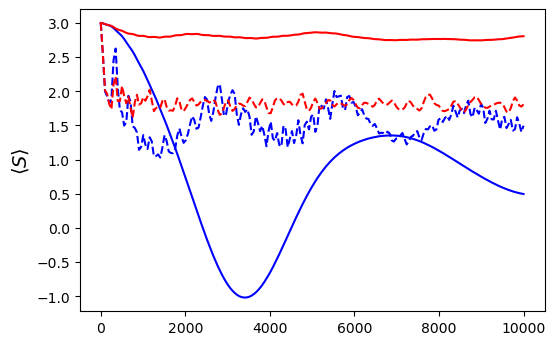

In [49]:
plt.figure()
T_quench = 10000
T_s = int(0.02*T_quench)
plt.plot(np.linspace(0,T_quench,T_s),av_S_0,'b--')
plt.plot(np.linspace(0,T_quench,T_s),av_S_0_opt,'b')
plt.plot(np.linspace(0,T_quench,T_s),av_S,'r--')
plt.plot(np.linspace(0,T_quench,T_s),av_S_opt,'r')
plt.xticks()
plt.ylabel(r'$\langle S\rangle$',fontsize=14)
plt.show()

In [43]:
def seq_quench(reg,para):
    seq_q = interp_seq(reg,para)
    seq_q.add(Pulse.ConstantPulse(RESULT_quench.x[0], RESULT_quench.x[1], RESULT_quench.x[2], 0.), 'ising')
    sim = Simulation(seq_q, sampling_rate=0.02)
    results = sim.run()
    expect_val = results.expect([occupation(j,N) for j in range(N)])
    stg_mag = sum([(-1)**j*expect_val[j] for j in range(1,N-1)])
    return stg_mag

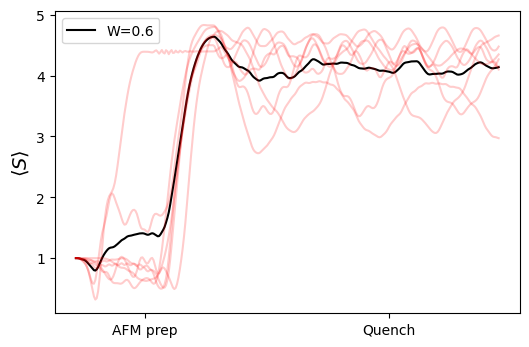

In [40]:
plt.figure()

plt.plot(np.mean([seq_quench(r['reg'],r['para']) for r in REGISTER_dict_opt.values()],axis=0),'k',label='W={}'.format(W))
for r in REGISTER_dict_opt.values():
    plt.plot(seq_quench(r['reg'],r['para']),'r',alpha=0.2)
plt.xticks([int(T*0.02/2),int((T+T_quench)*0.02/1.5)],['AFM prep','Quench'])
plt.ylabel(r'$\langle S\rangle$',fontsize=14)
plt.legend(loc=2)
plt.show()

In [ ]:
bounds_quench = [(2000,12000)]+[(U_0*0.1,U_0*1.25)]+[(0.5*U_0,5*U_0)]


def score_quench(para_quench):

    av_S = 0
    for r in REGISTER_dict_opt_0_dict.values():
        seq_q = seq_quench(r['reg'],r['para'],para_quench)
        seq_q.declare_channel('ising', 'rydberg_global')
        seq_q.add(Pulse.ConstantPulse(T_quench, Omega, delta, 0.), 'ising')
        sim = Simulation(seq_q, sampling_rate=0.02)
        results = sim.run(initial_state=AF_state)
        expect_val = results.expect([occupation(j,N) for j in range(N)])
        stg_mag = sum([(-1)**j*expect_val[j] for j in range(1,N-1)])
        av_S += np.mean(stg_mag)
    seq_q = Sequence(REG, Chadoq2)
    seq_q.declare_channel('ising', 'rydberg_global')
    seq_q.add(Pulse.ConstantPulse(T_quench, Omega, delta, 0.), 'ising')
    sim = Simulation(seq_q, sampling_rate=0.02)
    results = sim.run(initial_state=AF_state)
    expect_val = results.expect([occupation(j,N) for j in range(N)])
    stg_mag = sum([(-1)**j*expect_val[j] for j in range(1,N-1)])
    av_S_0 = np.mean(stg_mag)
    return abs(av_S_0) - av_S/K